## 🧸 Toy Example

### Pre-Debugging

In [13]:
# x = torch.Tensor([1])
x = torch.Tensor([[1], [2]])
print(x.shape)
if len(x.shape) == 1:
    x_view = x[:, None]
else:
    x_view = x
print(x_view.shape)

torch.Size([2, 1])
torch.Size([2, 1])


In [19]:
pos = torch.stack([x_view, x_view], dim=-1)

In [15]:
pos

tensor([[[1., 1.]],

        [[2., 2.]]])

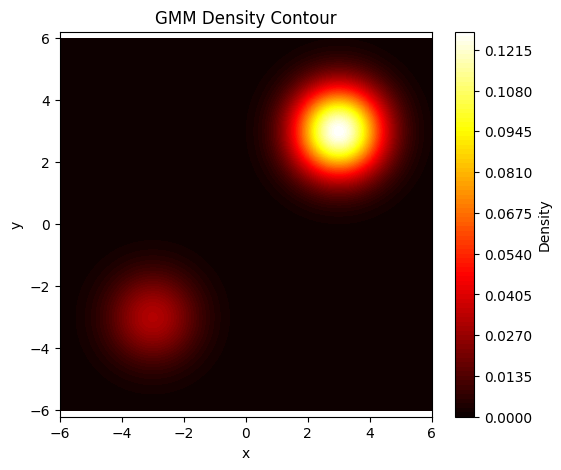

In [11]:
import numpy as np
import matplotlib.pyplot as plt

"""visualization of the GMM density for the Toy Example"""

def gmm_density(x, y):
    pos = torch.stack([x, y], axis=-1)
    # cov = np.eye(2)
    
    # Gaussian 1
    mu1 = torch.Tensor(np.array([3, 3]))
    diff1 = pos - mu1
    gauss1 = 0.8 * (1 / (2 * torch.pi)) * torch.exp(-0.5 * torch.sum(diff1**2, axis=-1))
    
    # Gaussian 2
    mu2 = torch.Tensor(np.array([-3, -3]))
    diff2 = pos - mu2
    gauss2 = 0.2 * (1 / (2 * torch.pi)) * torch.exp(-0.5 * torch.sum(diff2**2, axis=-1))

    return gauss1 + gauss2

# Create a grid
x = torch.linspace(-6, 6, 200)
y = torch.linspace(-6, 6, 200)
X, Y = torch.meshgrid(x, y, indexing="ij")
Z = gmm_density(X, Y)

# Plot
plt.figure(figsize=(6, 5))
plt.contourf(X, Y, Z, levels=100, cmap="hot")
plt.colorbar(label="Density")
plt.title("GMM Density Contour")
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")
plt.grid(False)
plt.show()


### Training Toy Example

In [1]:
import os, sys
import matplotlib.pyplot as plt
import numpy as np
import math

import torch
import torch.nn as nn


notebook_root = os.getcwd().replace('\\', '/')
dsac_root = os.path.dirname(notebook_root)
sys.path.append(dsac_root)
sys.path.append(f"{dsac_root}/soft_dac")

from diffusion.rssm_diffusion import ToyDiffusion

In [2]:
class Config:
    def __init__(self):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.learning_rate = 3e-4
        self.num_timesteps = 20 #diffusion steps
        self.hidden_layers = 2 #num_layers
        self.hidden_layer_neurons = 128 #hidden_size
        self.beta_schedule_mode = 'linear'
        self.beta_1 = 0.001
        self.beta_T = 0.999
        self.batch_size = 1024
        self.num_epochs = 300

        self.reverse_sampling_dist = 'gauss'
        self.time_embed_hidden_size=128
        self.time_dim=32

        self.input_dim=2
        self.output_dim=2

def _build_toy_diffusion(config):
    toy_diffusion = ToyDiffusion(
        device=config.device,
        input_dim=config.input_dim,
        hidden_size=config.hidden_layer_neurons,
        output_dim=config.output_dim,
        num_layers=config.hidden_layers,
        time_embed_hidden_size=config.time_embed_hidden_size,
        time_dim=config.time_dim,
        num_timesteps=config.num_timesteps,
        beta_1=config.beta_1,
        beta_T=config.beta_T,
        beta_schedule_mode=config.beta_schedule_mode,
        reverse_sampling_dist=config.reverse_sampling_dist
    )
    return toy_diffusion

In [3]:
# set random seed
RANDOM_SEED=42

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# additional settings for training
NUM_PTS_FOR_VIS=1000

DO_LOG=False #True #False

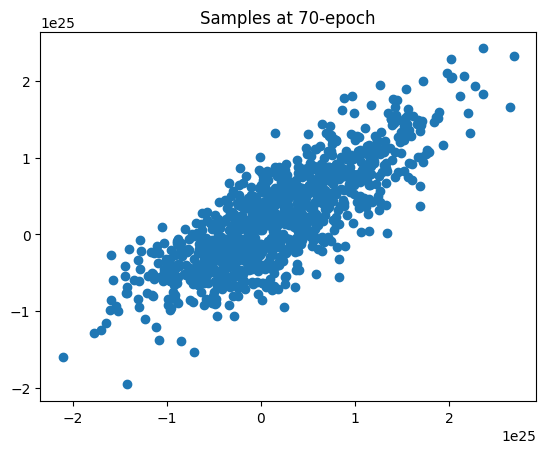

loss: 0.4154:  27%|██▋       | 80/300 [00:03<00:10, 21.61it/s]

tensor([[0.0000e+00],
        [6.4271e-09],
        [1.9574e-04],
        ...,
        [0.0000e+00],
        [3.7928e-02],
        [3.9246e-03]], device='cuda:0')
tensor([[0.0000e+00],
        [7.2205e-03],
        [0.0000e+00],
        ...,
        [0.0000e+00],
        [5.0609e-23],
        [1.1731e-25]], device='cuda:0')
tensor([[0.0000e+00],
        [0.0000e+00],
        [2.5924e-39],
        ...,
        [4.6950e-07],
        [0.0000e+00],
        [0.0000e+00]], device='cuda:0')
tensor([[0.0000e+00],
        [5.4329e-06],
        [0.0000e+00],
        ...,
        [0.0000e+00],
        [5.8458e-07],
        [0.0000e+00]], device='cuda:0')
tensor([[3.7396e-05],
        [1.3518e-03],
        [0.0000e+00],
        ...,
        [0.0000e+00],
        [3.1847e-06],
        [1.9557e-05]], device='cuda:0')
tensor([[0.0000e+00],
        [7.8889e-04],
        [0.0000e+00],
        ...,
        [0.0000e+00],
        [2.1628e-05],
        [0.0000e+00]], device='cuda:0')
tensor([[1.6811e-04],


interactive(children=(IntSlider(value=1, description='index', max=7), Output()), _dom_classes=('widget-interac…

Output()

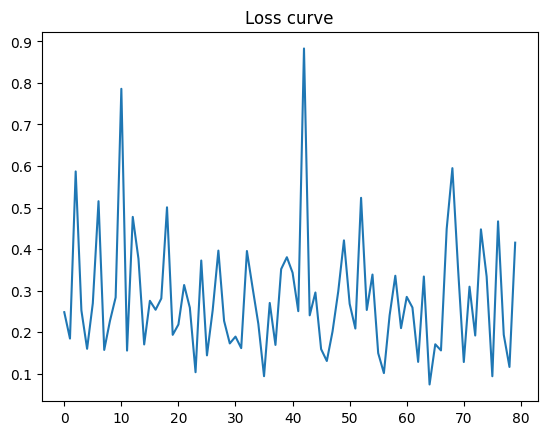

In [4]:
%load_ext autoreload
%autoreload 2


from tqdm import tqdm
from PIL import Image
import io

import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, Output
from IPython.display import display, clear_output

def figure2image(fig):
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = Image.open(buf)
    return img

config = Config()
toy_diffusion = _build_toy_diffusion(config=config)
# diffusion_model = toy_diffusion.model

pbar = tqdm(range(config.num_epochs))
optimizer = torch.optim.Adam(toy_diffusion.parameters(), lr=config.learning_rate)


losses = []
images = []
try:
    for epoch in pbar:
        toy_diffusion.model.train()
        optimizer.zero_grad()
        

        loss = toy_diffusion.compute_rssm_loss(batch_size=config.batch_size,
                                                    x_shape=(config.batch_size, config.input_dim),
                                                    do_log=DO_LOG)

        loss.backward()
        optimizer.step()
        pbar.set_description(f"loss: {loss.item():.4f}")
        
        losses.append(loss.item())
        
        if epoch % 10 == 0:
            with torch.no_grad():
                toy_diffusion.model.eval()
                x0 = toy_diffusion.p_sample_loop(shape=(NUM_PTS_FOR_VIS, config.input_dim)).cpu()
                fig, ax = plt.subplots(1,1)
                ax.scatter(x0[:,0], x0[:,1])
                ax.set_title(f"Samples at {epoch}-epoch")
                clear_output(wait=True)
                plt.show()
                img = figure2image(fig)
                images.append(img)
                
except KeyboardInterrupt:
    pass
finally:
    if len(images) > 0:
        slider = IntSlider(min=0, max=len(images)-1, step=1, value=1)
        output = Output()
        def display_image(index):
            with output:
                output.clear_output(wait=True)
                display(images[index])
        interact(display_image, index=slider)
        display(output)
        plt.plot(losses)
        plt.title("Loss curve")

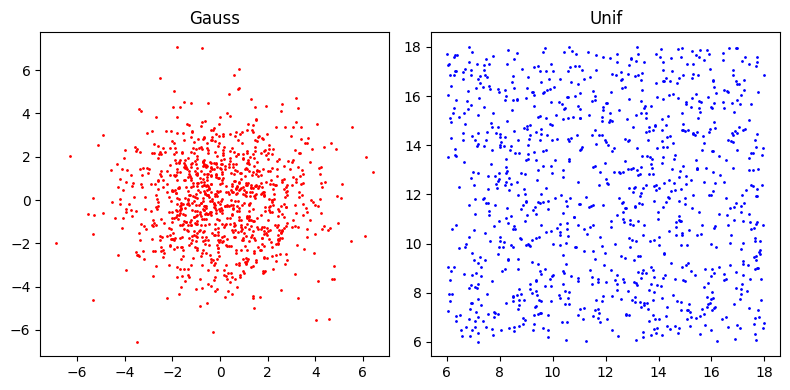

In [8]:
shape = (1024, 2)
import torch
import matplotlib.pyplot as plt
gauss_x = torch.randn(shape) * 2
unif_x = 12 * torch.rand(shape) + 6

fig,ax = plt.subplots(1, 2, figsize=(8,4))
ax[0].scatter(gauss_x[:, 0], gauss_x[:, 1], c='r', s=1);ax[0].set_title("Gauss")
ax[1].scatter(unif_x[:, 0], unif_x[:, 1], c='b', s=1);ax[1].set_title("Unif")
plt.tight_layout()

In [10]:
betas = torch.linspace(0.001, 0.999, steps=20)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)

In [11]:
alphas_cumprod

tensor([9.9900e-01, 9.4553e-01, 8.4525e-01, 7.1121e-01, 5.6107e-01, 4.1316e-01,
        2.8253e-01, 1.7837e-01, 1.0324e-01, 5.4330e-02, 2.5738e-02, 1.0841e-02,
        3.9970e-03, 1.2637e-03, 3.3314e-04, 7.0328e-05, 1.1153e-05, 1.1828e-06,
        6.3309e-08, 6.3308e-11])

In [13]:
import numpy as np
timesteps = torch.from_numpy(
    np.arange(0, 20)[::-1].copy()
).long()

print(timesteps)

tensor([19, 18, 17, 16, 15, 14, 13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2,
         1,  0])


In [6]:
t = torch.randint(0, 20, size=(1024,))
print(t[:10])

tensor([ 3,  3,  6, 12, 13, 14,  1, 15,  1,  2])


In [10]:
toy_diffusion.gmm_density_torch(x0=torch.Tensor([[3, 3]]).to('cuda'))

tensor([0.1273], device='cuda:0')

In [ ]:
print(gmm_density(torch.Tensor([3]), torch.Tensor([3])))
print(gmm_density(torch.Tensor([-3]), torch.Tensor([-3])))

tensor([0.1273])
tensor([0.0318])
